## Statistical Machine Learning Project
### Adversarial attacks

In this notebook I'll try to implement a trained model based on [MNIST dataset](http://yann.lecun.com/exdb/mnist/) and later using some attacks and defenses based on [DeepRobust library](https://github.com/DSE-MSU/DeepRobust)

In [0]:
# Mount on Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Going to my directory

%cd gdrive/My\ Drive/Colab Notebooks/rob

[Errno 2] No such file or directory: 'gdrive/My Drive/Colab Notebooks/rob'
/content/gdrive/My Drive/Colab Notebooks/rob


In [0]:
# Install DeepRobust

!pip install --upgrade texttable git+https://github.com/DSE-MSU/DeepRobust.git

  Cloning https://github.com/DSE-MSU/DeepRobust.git to /tmp/pip-req-build-ny2o4cul
  Running command git clone -q https://github.com/DSE-MSU/DeepRobust.git /tmp/pip-req-build-ny2o4cul
Requirement already up-to-date: texttable in /usr/local/lib/python3.6/dist-packages (1.6.2)
  Created wheel for deeprobust: filename=deeprobust-0-cp36-none-any.whl size=142381 sha256=589a35e8bb320df09a6390533aad2fcdb0001dc019315f292f244826f890f694
  Stored in directory: /tmp/pip-ephem-wheel-cache-6yum2l18/wheels/b7/ca/29/c849fd24b965c2d46dcddd6403279a73b77328ef140fc8a88a
Successfully built deeprobust
  Found existing installation: deeprobust 0
    Uninstalling deeprobust-0:
      Successfully uninstalled deeprobust-0


In [0]:
# LIBRARIES

import deeprobust.image.netmodels.train_model as trainmodel
from deeprobust.image.attack.pgd import PGD
from deeprobust.image.attack.onepixel import Onepixel
from deeprobust.image.config import attack_params
import torch
import deeprobust.image.netmodels.CNN as MODEL
from torchvision import transforms, datasets
from deeprobust.image.defense.pgdtraining import PGDtraining
from deeprobust.image.config import defense_params
from deeprobust.image.netmodels.CNN import Net
import matplotlib.pyplot as plt

In [0]:
%pwd

'/content/gdrive/My Drive/Colab Notebooks/rob'

In [0]:
# Train model for MNIST dataset

trainmodel.train('CNN', 'MNIST', 'cuda', 20, '.')

1
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.297278
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.245467
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.162478
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.028683
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.759927
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.339876
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.995444
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.709786
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.716057
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.560821
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.547404
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.346409
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.472938
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.453096
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.291966
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.405553
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.174750
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.400593
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.374225
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.565952
Train Epoch: 1 [12800/60000

In [0]:
acc_test = 9921/10000
acc_test

0.9921

In [0]:
%ls

 build/                                deeprobust/   MNIST/
'Copia di Celebrities.ipynb'           DeepRobust/   MNIST_attacks.ipynb
'Copia di Copy of stl10attack.ipynb'   dist/         trained_models/


In [0]:
model = MODEL.Net().to('cuda')
model.load_state_dict(torch.load("./trained_models/MNIST_CNN_epoch_20.pt", map_location='cuda'))
model.eval()

transform_val = transforms.Compose([transforms.ToTensor()])
test_loader  = torch.utils.data.DataLoader(
                datasets.MNIST('deeprobust/image/data', train = False, download=True,
                transform = transform_val),
                batch_size = 1, shuffle=True)

Extracting deeprobust/image/data/MNIST/raw/train-images-idx3-ubyte.gz to deeprobust/image/data/MNIST/raw


Extracting deeprobust/image/data/MNIST/raw/train-labels-idx1-ubyte.gz to deeprobust/image/data/MNIST/raw


Extracting deeprobust/image/data/MNIST/raw/t10k-images-idx3-ubyte.gz to deeprobust/image/data/MNIST/raw


Extracting deeprobust/image/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to deeprobust/image/data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


torch.Size([1, 1, 28, 28])


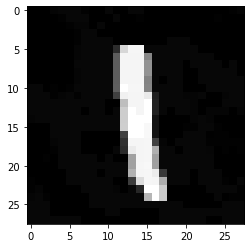

In [0]:
x, y = next(iter(test_loader))
x = x.to('cuda').float()

adversary = PGD(model, 'cpu')
Adv_img = adversary.generate(x, y)
print(Adv_img.size())

plt.imshow(Adv_img[0][0].detach().numpy(), cmap='gray')

In [0]:
# Evaluate model on adversarial attacks

correct = 0
batch_number = 0
for data, target in test_loader:
  
  batch_number +=1
  #Send the data and label to the device
  data, target = data.to('cuda'), target.to('cuda')
  batch_size = data.size()[0]

  # Call PGD Attack
  adversary = PGD(model, 'cuda')
  Adv_img = adversary.generate(data, target)

  # Re-classify the perturbed image
  output = model(Adv_img)

  # Check for success
  final_pred = torch.argmax(output, dim=1) # get the index of the max log-probability

  if final_pred.item() == target.item():
      correct += 1

  print(f'Evaluation of adversarial attacks: [{batch_number} / {10000}]')

final_acc = correct/float(len(test_loader)*acc_test)
print("Test Accuracy = {} / {} = {}".format(correct, len(test_loader)*acc_test, final_acc))



Streaming output truncated to the last 5000 lines.
Evaluation of adversarial attacks: [5003 / 10000]
Evaluation of adversarial attacks: [5004 / 10000]
Evaluation of adversarial attacks: [5005 / 10000]
Evaluation of adversarial attacks: [5006 / 10000]
Evaluation of adversarial attacks: [5007 / 10000]
Evaluation of adversarial attacks: [5008 / 10000]
Evaluation of adversarial attacks: [5009 / 10000]
Evaluation of adversarial attacks: [5010 / 10000]
Evaluation of adversarial attacks: [5011 / 10000]
Evaluation of adversarial attacks: [5012 / 10000]
Evaluation of adversarial attacks: [5013 / 10000]
Evaluation of adversarial attacks: [5014 / 10000]
Evaluation of adversarial attacks: [5015 / 10000]
Evaluation of adversarial attacks: [5016 / 10000]
Evaluation of adversarial attacks: [5017 / 10000]
Evaluation of adversarial attacks: [5018 / 10000]
Evaluation of adversarial attacks: [5019 / 10000]
Evaluation of adversarial attacks: [5020 / 10000]
Evaluation of adversarial attacks: [5021 / 10000]

In [0]:
%rm -r deeprobust/image/

In [0]:
train_loader = torch.utils.data.DataLoader(
                datasets.MNIST('deeprobust/image/defense/data', train=True, download=True,
                                transform=transforms.Compose([transforms.ToTensor()])),
                                batch_size=100,shuffle=True)

test_loader = torch.utils.data.DataLoader(
              datasets.MNIST('deeprobust/image/defense/data', train=False,
                            transform=transforms.Compose([transforms.ToTensor()])),
                            batch_size=100,shuffle=True)



Extracting deeprobust/image/defense/data/MNIST/raw/train-images-idx3-ubyte.gz to deeprobust/image/defense/data/MNIST/raw


Extracting deeprobust/image/defense/data/MNIST/raw/train-labels-idx1-ubyte.gz to deeprobust/image/defense/data/MNIST/raw


Extracting deeprobust/image/defense/data/MNIST/raw/t10k-images-idx3-ubyte.gz to deeprobust/image/defense/data/MNIST/raw


Extracting deeprobust/image/defense/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to deeprobust/image/defense/data/MNIST/raw
Processing...
Done!


In [0]:
model = Net()

defense = PGDtraining(model, 'cuda')
defense.generate(train_loader=train_loader, test_loader=test_loader, epsilon=0.3, epoch= 50,
                 lr = 0.001, save_dir='./defense_model', save_model = True, save_name= 'mnist_fgsmtraining_0.2.pt')

1
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.393904	Accuracy:0.00%
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.317958	Accuracy:0.80%
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.329497	Accuracy:1.00%
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.334179	Accuracy:1.50%
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.291698	Accuracy:1.50%
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.447279	Accuracy:1.40%
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.275604	Accuracy:2.00%
Train Epoch: 1 [7000/60000 (12%)]	Loss: 2.201716	Accuracy:2.20%
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.081842	Accuracy:2.90%
Train Epoch: 1 [9000/60000 (15%)]	Loss: 2.151199	Accuracy:2.10%
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.128443	Accuracy:1.90%
Train Epoch: 1 [11000/60000 (18%)]	Loss: 1.936079	Accuracy:3.60%
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.921065	Accuracy:3.20%
Train Epoch: 1 [13000/60000 (22%)]	Loss: 1.926522	Accuracy:2.90%
Train Epoch: 1 [14000/60000 (23%)]	Loss: 1.883466	Accuracy:2.00%
Train Epoch: 1 [15000/60000 (25%)]	Loss: 1

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)